In [1]:
import torchvision
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms, models
from torchvision.datasets import Food101

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

  losses = []
  accuracies = []

  net.to(device)

  for e in range(epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / train_dataset_length

    print(f"Loss-ul la finalul epocii {e + 1}: {epoch_loss}")

    acc = test_acc(net, test_loader)
    print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

    losses.append(epoch_loss)
    accuracies.append(acc)

    torch.save(net.state_dict(), f'resnet50_multiplefclayers_adamw_epoch{e + 1}.pkl')

  loss_graph(losses)
  accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vlad Talpiga.VLR_PROJAMZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started
Loss-ul la finalul epocii 1: 2.307724251574022
Acuratetea la finalul epocii 1 este 59.22%
Loss-ul la finalul epocii 2: 1.8926097719991954
Acuratetea la finalul epocii 2 este 61.37%
Loss-ul la finalul epocii 3: 1.8082895222560014
Acuratetea la finalul epocii 3 este 63.15%
Loss-ul la finalul epocii 4: 1.7512480282201233
Acuratetea la finalul epocii 4 este 64.30%
Loss-ul la finalul epocii 5: 1.6981035249728968
Acuratetea la finalul epocii 5 este 65.04%
Loss-ul la finalul epocii 6: 1.6610846661419758
Acuratetea la finalul epocii 6 este 65.81%
Loss-ul la finalul epocii 7: 1.6365883738955256
Acuratetea la finalul epocii 7 este 66.36%
Loss-ul la finalul epocii 8: 1.608260371494608
Acuratetea la finalul epocii 8 este 66.82%
Loss-ul la finalul epocii 9: 1.5815104687851254
Acuratetea la finalul epocii 9 este 67.32%
Loss-ul la finalul epocii 10: 1.569978257534921
Acuratetea la finalul epocii 10 este 68.29%
Loss-ul la finalul epocii 11: 1.5483479077430449
Acuratetea la finalul epo

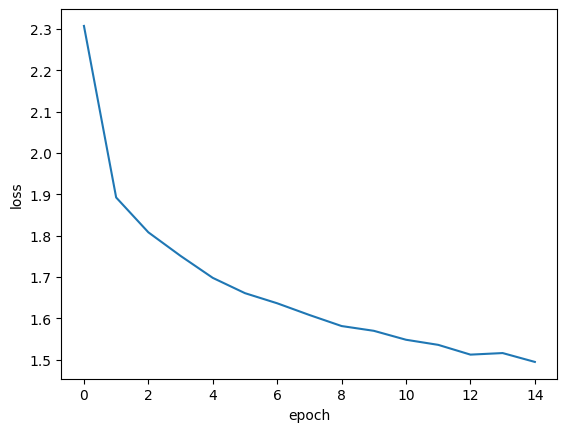

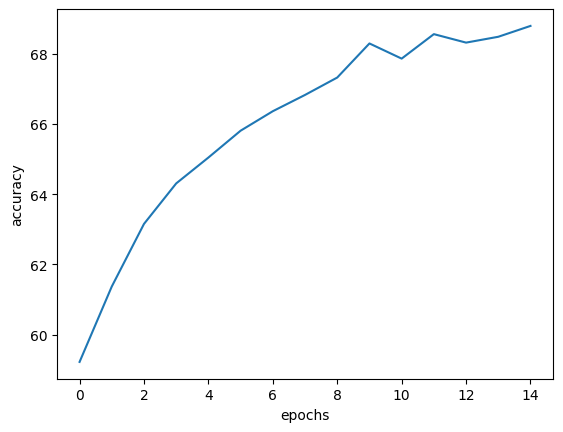

Duration of training: 344.1185669581095


In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 101)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(train_dataset.classes)
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Freeze all layers except the final classification layer
for param in resnet.parameters():
    param.requires_grad = False

resnet = nn.Sequential(
    resnet,
    CustomClassifier()
)

# print(*list(resnet.children()))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=0.001, betas=(0.95, 0.999), weight_decay=0.0001)
 
epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, resnet, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch.nn as nn
from torchvision import transforms, models

class Food101Dataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = sorted(os.listdir(data_folder))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls_name in self.classes:
            cls_path = os.path.join(self.data_folder, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformation for the images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your data folder
data_folder = "C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/data/food-101/images"

# Create dataset
food101_dataset = Food101Dataset(data_folder, transform=transform)

# Create dataloader
batch_size = 32
data_loader = DataLoader(food101_dataset, batch_size=batch_size, shuffle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0
  top2_correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

    _, predicted2 = torch.topk(outputs, 2, dim=1)  # Get top 2 predictions
    top2_correct += ((predicted2 == labels.view(-1, 1)) | (predicted2[:, 1].view(-1, 1) == labels.view(-1, 1))).sum().item()

  return (correct / total * 100, top2_correct / total * 100)

# def test_top2_acc(net: nn.Module, test_loader: DataLoader):

#   net.to(device)
#   net.eval()
  
#   total = 0
#   top2_correct = 0

#   for images, labels in test_loader:
#     images, labels = images.to(device), labels.to(device)
#     total += labels.size(0)

#     outputs = net(images)
#     _, predicted = torch.topk(outputs, 2, dim=1)  # Get top 2 predictions
#     top2_correct += ((predicted == labels.view(-1, 1)) | (predicted[:, 1].view(-1, 1) == labels.view(-1, 1))).sum().item()

#   return top2_correct / total * 100

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
class CustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

num_classes = len(food101_dataset.classes)
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet.parameters():
    param.requires_grad = False

model = nn.Sequential(
    resnet,
    CustomClassifier(num_classes)
)

In [6]:
start = time.time()
for i in range(1, 16):

    state_dict = torch.load(f'C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/cross_validation/resnet_not_dropout_sgd_best/resnet50_multiplefclayers_adamw_epoch{i}.pkl')
    model.load_state_dict(state_dict)

    accuracy, top2accuracy = test_acc(model, data_loader)

    print(f'Epoch {i}: accuracy - {accuracy:.3f}%, top 2 accuracy - {top2accuracy:.3f}%')

print(f'Testing duration: {time.time() - start}')

Epoch 1: accuracy - 57.289%, top 2 accuracy - 81.950%
Epoch 2: accuracy - 61.270%, top 2 accuracy - 85.211%
Epoch 3: accuracy - 62.821%, top 2 accuracy - 86.599%
Epoch 4: accuracy - 65.024%, top 2 accuracy - 87.780%


KeyboardInterrupt: 

In [ ]:
start = time.time()
for i in range(1, 16):

    state_dict = torch.load(f'C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/IAVA/Proiect/FoodClassifier/cross_validation/resnet_dropout/resnet50_multiplefclayers_adamw_epoch{i}.pkl')
    model.load_state_dict(state_dict)

    accuracy = test_acc(model, data_loader)
    top2accuracy = test_top2_acc(model, data_loader)

    print(f'Epoch {i}: accuracy - {accuracy:.3f}%, top 2 accuracy - {top2accuracy:.3f}%')

print(f'Testing duration: {time.time() - start}')